In [54]:
#tous les imports ici :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import seaborn as sns
import os

In [12]:
df = pd.read_csv('../raw_data/supply_chain_dataset1.csv')
df.head()

,Date,SKU_ID,Warehouse_ID,Supplier_ID,Region,Units_Sold,Inventory_Level,Supplier_Lead_Time_Days,Reorder_Point,Order_Quantity,Unit_Cost,Unit_Price,Promotion_Flag,Stockout_Flag,Demand_Forecast
0,2024-01-01,SKU_1,WH_1,SUP_8,West,10,592,14,379,0,13.95,20.48,0,0,8.52
1,2024-01-02,SKU_1,WH_1,SUP_8,West,17,575,14,379,0,13.95,20.48,0,0,18.63
2,2024-01-03,SKU_1,WH_1,SUP_8,North,35,540,14,379,0,13.95,20.48,1,0,39.62
3,2024-01-04,SKU_1,WH_1,SUP_8,South,24,516,14,379,0,13.95,20.48,0,0,19.43
4,2024-01-05,SKU_1,WH_1,SUP_8,West,21,495,14,379,0,13.95,20.48,0,0,18.70


In [13]:
# Infos sur les colonnes et types :
df.info()

# Statistiques descriptives pour les colonnes numériques :
df.describe()

# Vérifier les doublons :
df.duplicated().sum()

# Vérifier les valeurs manquantes :
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91250 entries, 0 to 91249
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     91250 non-null  object 
 1   SKU_ID                   91250 non-null  object 
 2   Warehouse_ID             91250 non-null  object 
 3   Supplier_ID              91250 non-null  object 
 4   Region                   91250 non-null  object 
 5   Units_Sold               91250 non-null  int64  
 6   Inventory_Level          91250 non-null  int64  
 7   Supplier_Lead_Time_Days  91250 non-null  int64  
 8   Reorder_Point            91250 non-null  int64  
 9   Order_Quantity           91250 non-null  int64  
 10  Unit_Cost                91250 non-null  float64
 11  Unit_Price               91250 non-null  float64
 12  Promotion_Flag           91250 non-null  int64  
 13  Stockout_Flag            91250 non-null  int64  
 14  Demand_Forecast       

Date                       0
SKU_ID                     0
Warehouse_ID               0
Supplier_ID                0
Region                     0
Units_Sold                 0
Inventory_Level            0
Supplier_Lead_Time_Days    0
Reorder_Point              0
Order_Quantity             0
Unit_Cost                  0
Unit_Price                 0
Promotion_Flag             0
Stockout_Flag              0
Demand_Forecast            0
dtype: int64

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop_duplicates()

#vérif des IDs :
df['SKU_ID'] = df['SKU_ID'].str.strip()
df['Warehouse_ID'] = df['Warehouse_ID'].str.strip()
df['Supplier_ID'] = df['Supplier_ID'].str.strip()
df['Region'] = df['Region'].str.strip()

#création de nouvelles colonnes :
df['Stock_After_Sale'] = df['Inventory_Level'] - df['Units_Sold']
df['Inventory_Value'] = df['Inventory_Level'] * df['Unit_Cost']

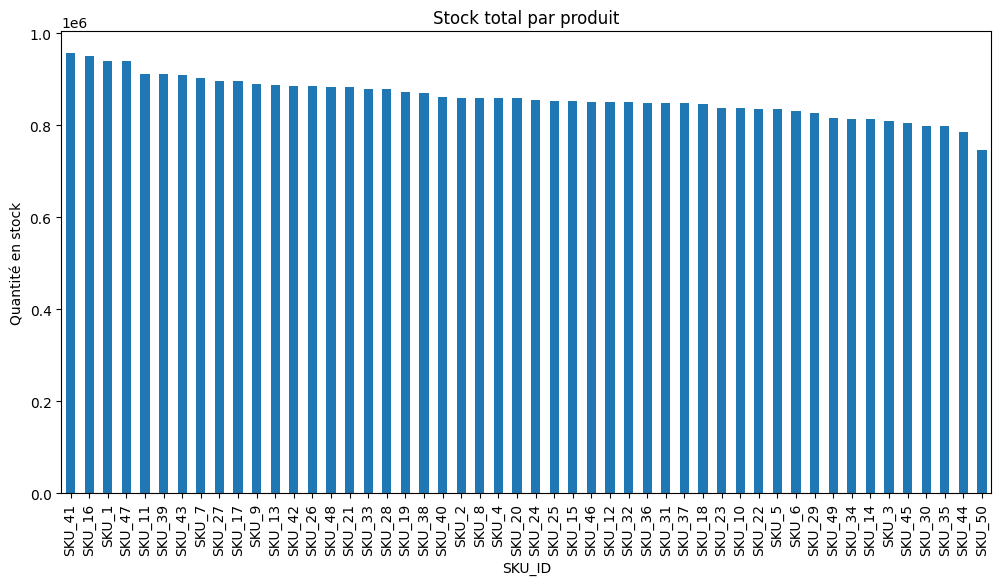

In [15]:
#Analyse par produit :
# Stock total par produit :
stock_par_produit = df.groupby('SKU_ID')['Inventory_Level'].sum().sort_values(ascending=False)

# Visualisation :
plt.figure(figsize=(12,6))
stock_par_produit.plot(kind='bar')
plt.title('Stock total par produit')
plt.ylabel('Quantité en stock')
plt.show()

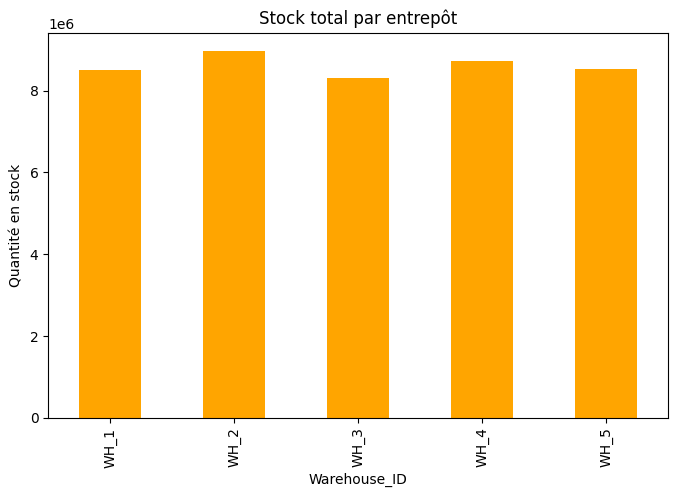

In [16]:
# Analyse par Entrepôt :
stock_par_entrepot = df.groupby('Warehouse_ID')['Inventory_Level'].sum()

plt.figure(figsize=(8,5))
stock_par_entrepot.plot(kind='bar', color='orange')
plt.title('Stock total par entrepôt')
plt.ylabel('Quantité en stock')
plt.show()

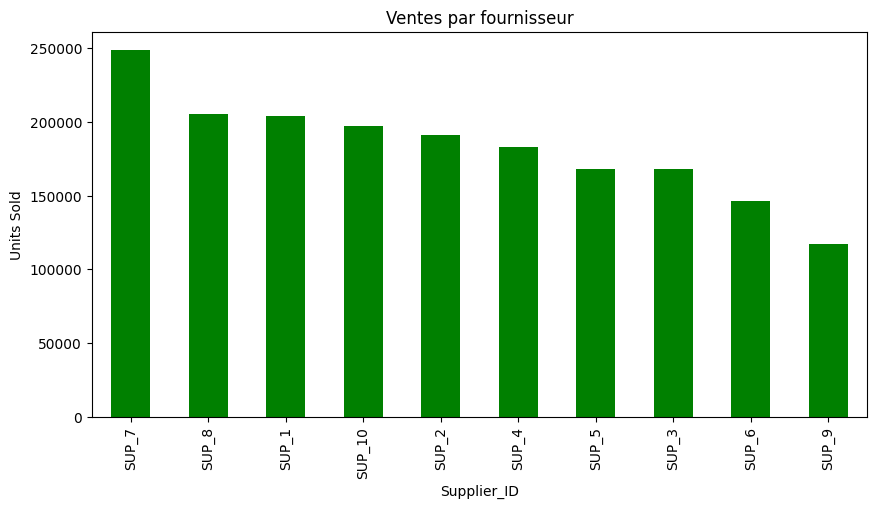

In [17]:
# Analyse des fournisseurs :
units_par_fournisseur = df.groupby('Supplier_ID')['Units_Sold'].sum()

plt.figure(figsize=(10,5))
units_par_fournisseur.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Ventes par fournisseur')
plt.ylabel('Units Sold')
plt.show()

In [18]:
#Produits par entrepôt :
pivot = df.pivot_table(
    index='SKU_ID',
    columns='Warehouse_ID',
    values='Inventory_Level',
    aggfunc='sum'
)
pivot.head()

Warehouse_ID,WH_1,WH_2,WH_3,WH_4,WH_5
SKU_ID,,,,,
SKU_1,202775,179762,176545,180589,199623
SKU_10,192495,171693,140618,184006,149188
SKU_11,176711,155781,184391,206327,189408
SKU_12,168276,188769,150588,156324,187151
SKU_13,160820,189734,202109,162007,172003


In [19]:
#
pivot.reset_index(inplace=True)

In [20]:
pip install gspread gspread_dataframe google-auth


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials

scopes = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]
creds = Credentials.from_service_account_file('../raw_data/credentials.json', scopes=scopes)
gc = gspread.authorize(creds)

sheet_id = "1xXGenAwbKl4K5F_mC31TqbLIQCBFUo9Ze23UURqfunU"
sh = gc.open_by_key(sheet_id)

worksheet = sh.get_worksheet(0)

df = df.applymap(lambda x: int(x) if isinstance(x, (np.int64, np.int32)) else x)

set_with_dataframe(worksheet, test_df)


/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/192858360.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: int(x) if isinstance(x, (np.int64, np.int32)) else x)


In [47]:
def convert_types(df):
    for col in df.select_dtypes(include=[np.int64, np.int32]).columns:
        df[col] = df[col].astype(int)
    for col in df.select_dtypes(include=[np.float64]).columns:
        df[col] = df[col].astype(float)
    return df

In [48]:
#Pas de ruptures -> on va les simuler pr notre test :
df.loc[np.random.choice(df.index, 10, replace=False), "Stockout_Flag"] = 1

In [49]:
# === 1. Stats globales ===
stats_globales = df.describe(include="all")
try:
    worksheet1 = sh.worksheet("Stats Globales")
except gspread.exceptions.WorksheetNotFound:
    worksheet1 = sh.add_worksheet(title="Stats Globales", rows=200, cols=20)
    set_with_dataframe(worksheet1, stats_globales)

# === 2. Stocks par région et entrepôt ===
pivot_stocks = pd.pivot_table(
    df,
    values="Inventory_Level",
    index=["Region", "Warehouse_ID"],
    aggfunc="mean"
).reset_index()
worksheet2 = sh.add_worksheet(title="Stocks Région/Entrepôt", rows=200, cols=20)
set_with_dataframe(worksheet2, pivot_stocks)

# === 3. Top 10 sous-stock ===
ruptures = df[df["Stockout_Flag"] == 1]
top10_stockouts = (
    ruptures.groupby("SKU_ID")
    .agg(
        Nb_Ruptures=("Stockout_Flag", "sum"),
        Stock_Moyen=("Inventory_Level", "mean"),
        CA_Potentiel=("Unit_Price", lambda x: (x * df.loc[x.index, "Units_Sold"]).sum()),
        Region_Principale=("Region", lambda x: x.value_counts().idxmax())
    )
    .reset_index()
    .sort_values("Nb_Ruptures", ascending=False)
    .head(10)
)
top10_stockouts = top10_stockouts.applymap(lambda x: int(x) if isinstance(x, (np.int64, np.int32)) else x)

worksheet3 = sh.add_worksheet(title="Top 10 Ruptures", rows=200, cols=20)
set_with_dataframe(worksheet3, top10_stockouts)

/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/1761274569.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top10_stockouts = top10_stockouts.applymap(lambda x: int(x) if isinstance(x, (np.int64, np.int32)) else x)


/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/666011355.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


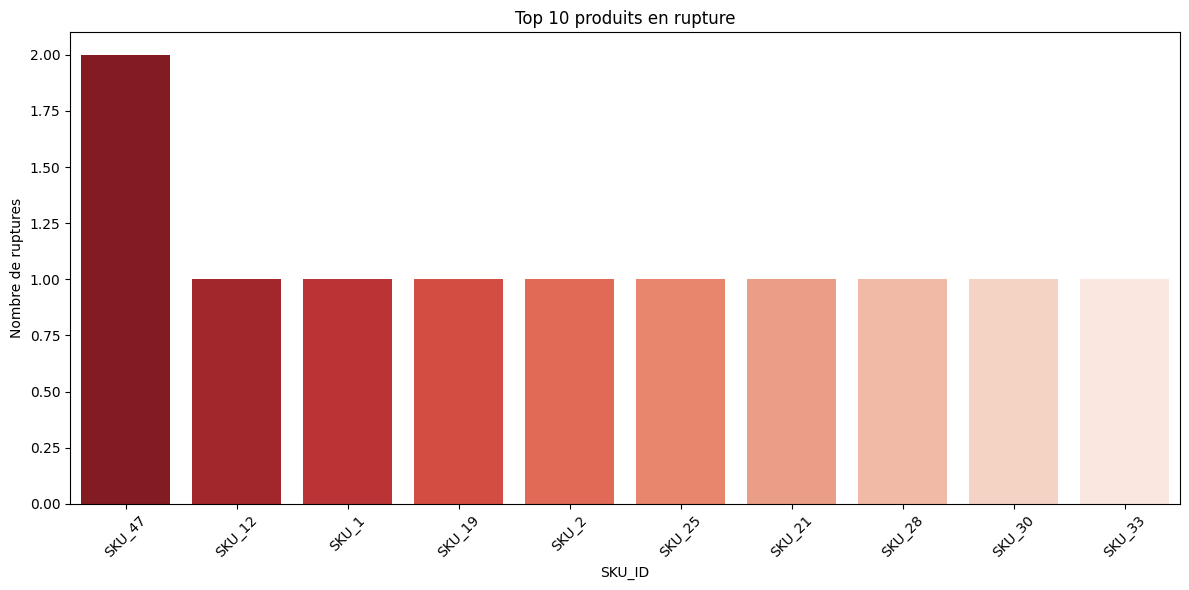

/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/666011355.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/666011355.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


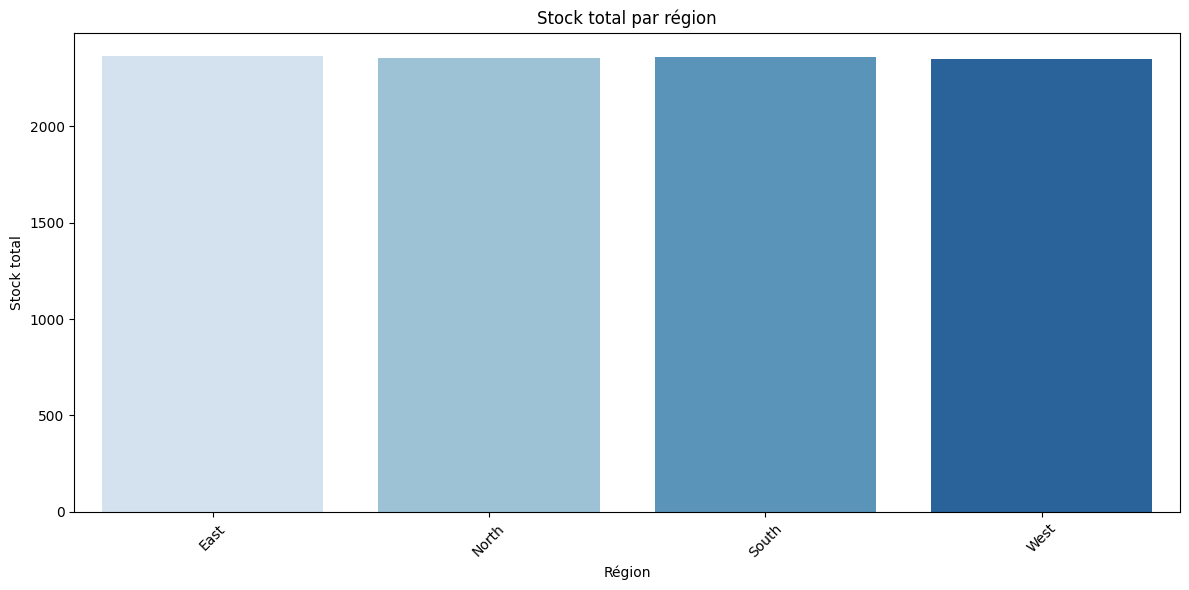

In [51]:
#Visualisation des ruptures par produit
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_stockouts,
    x="SKU_ID",
    y="Nb_Ruptures",
    palette="Reds_r"
)
plt.title("Top 10 produits en rupture")
plt.xlabel("SKU_ID")
plt.ylabel("Nombre de ruptures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisation des stocks par région :
plt.figure(figsize=(12,6))
sns.barplot(
    data=pivot_stocks,
    x="Region",
    y="Inventory_Level",
    estimator=sum,  # somme des stocks par région
    ci=None,
    palette="Blues"
)
plt.title("Stock total par région")
plt.xlabel("Région")
plt.ylabel("Stock total")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/635212223.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


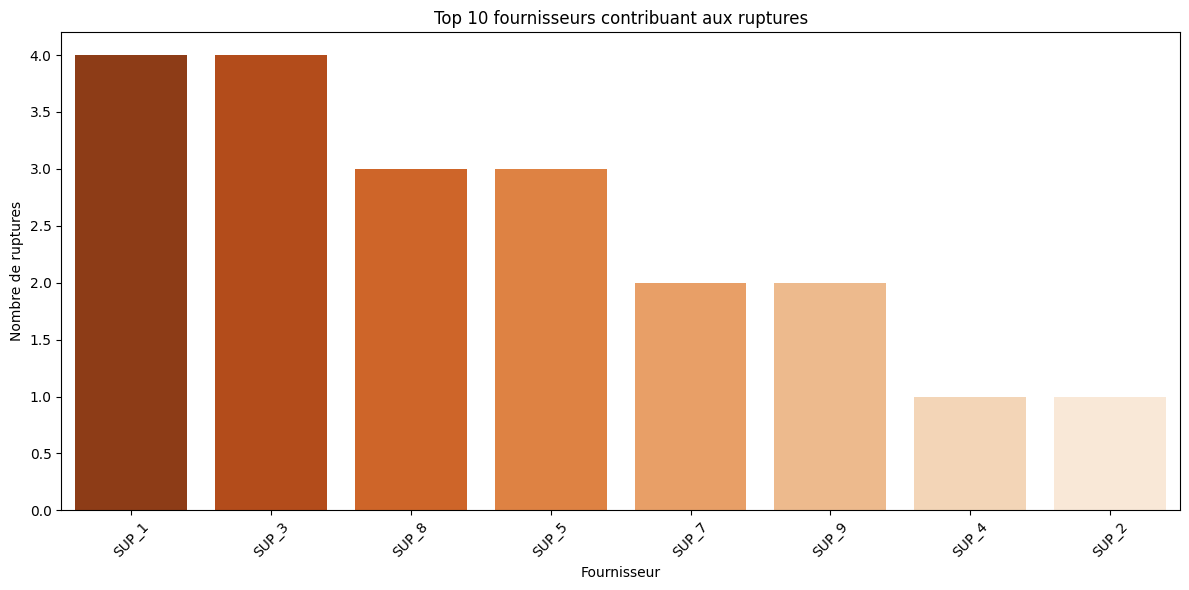

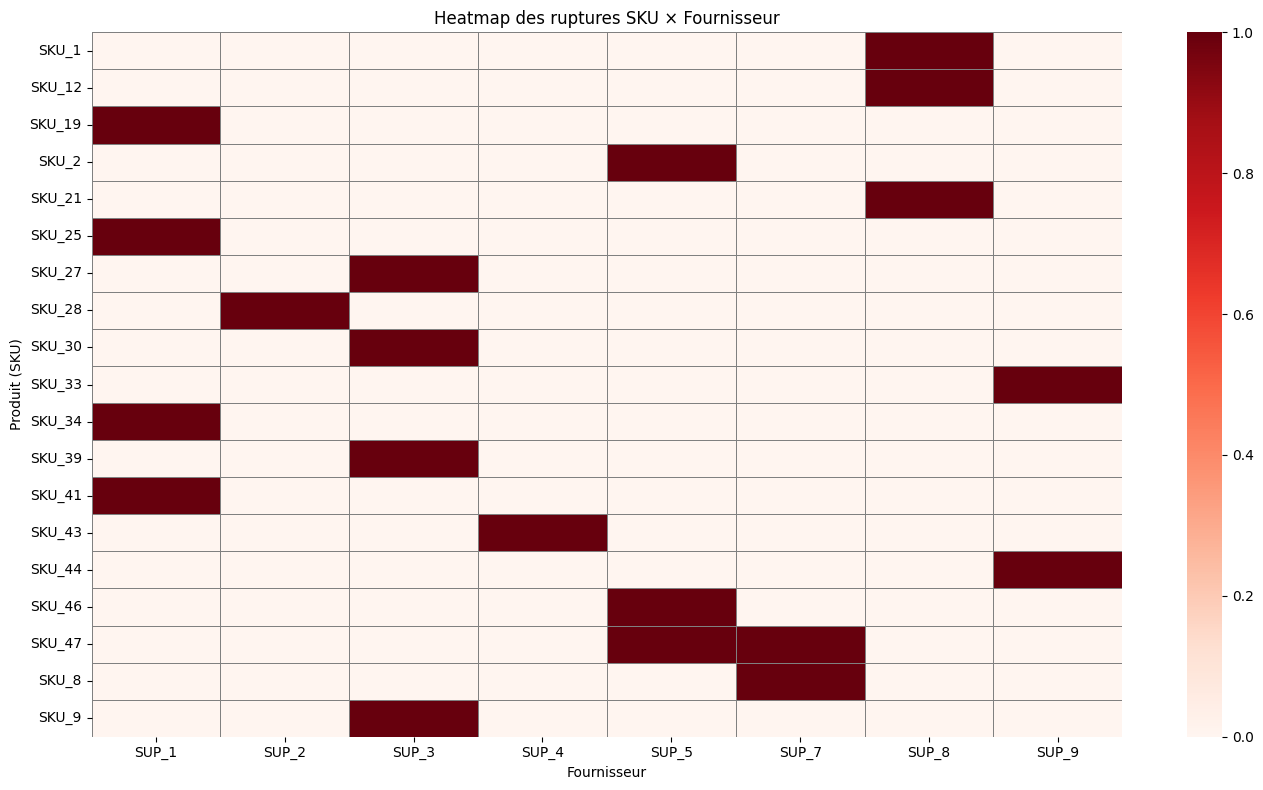

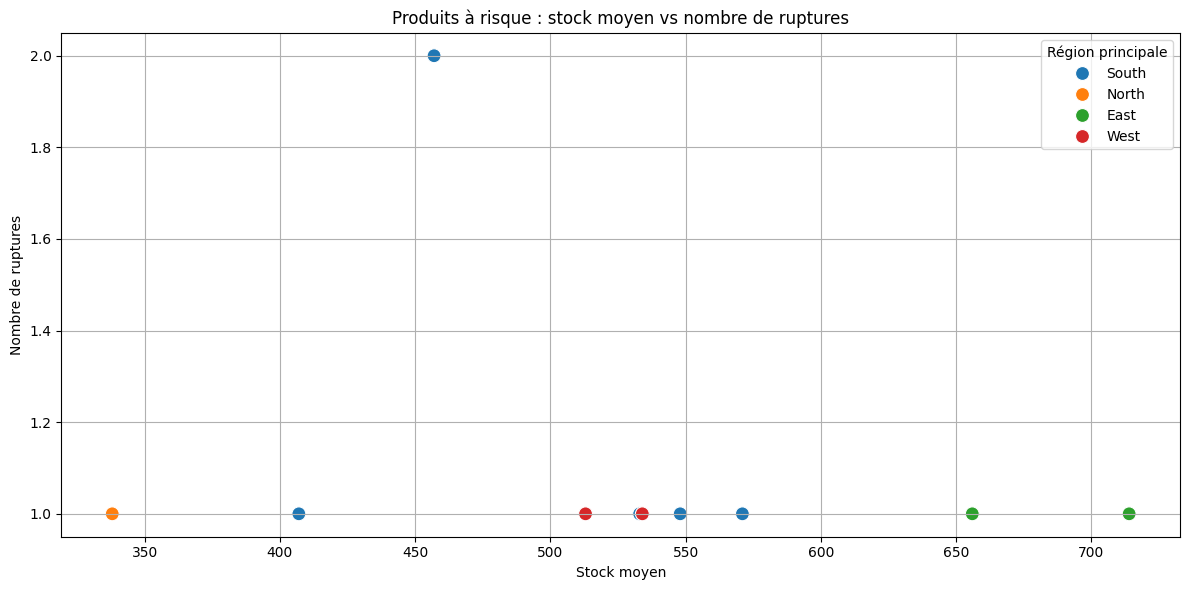

In [52]:
# Dashboard fournisseurs et risques de rupture
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 fournisseurs par nombre de ruptures
top_fournisseurs = (
    ruptures.groupby("Supplier_ID")
    .agg(Nb_Ruptures=("Stockout_Flag", "sum"))
    .reset_index()
    .sort_values("Nb_Ruptures", ascending=False)
    .head(10)
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=top_fournisseurs,
    x="Supplier_ID",
    y="Nb_Ruptures",
    palette="Oranges_r"
)
plt.title("Top 10 fournisseurs contribuant aux ruptures")
plt.xlabel("Fournisseur")
plt.ylabel("Nombre de ruptures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Heatmap SKU × Fournisseur pour visualiser dépendances critiques
pivot_heatmap = (
    ruptures.pivot_table(
        index="SKU_ID",
        columns="Supplier_ID",
        values="Stockout_Flag",
        aggfunc="sum",
        fill_value=0
    )
)

plt.figure(figsize=(14,8))
sns.heatmap(
    pivot_heatmap,
    cmap="Reds",
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Heatmap des ruptures SKU × Fournisseur")
plt.xlabel("Fournisseur")
plt.ylabel("Produit (SKU)")
plt.tight_layout()
plt.show()


# Scatter Stock moyen × Nb de ruptures (produits à risque)
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=top10_stockouts,
    x="Stock_Moyen",
    y="Nb_Ruptures",
    hue="Region_Principale",
    palette="tab10",
    s=100
)
plt.title("Produits à risque : stock moyen vs nombre de ruptures")
plt.xlabel("Stock moyen")
plt.ylabel("Nombre de ruptures")
plt.legend(title="Région principale")
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
output_dir = "exports_powerbi/"

os.makedirs(output_dir, exist_ok=True)

# 1️⃣ Pivot stocks région/entrepôt
pivot_stocks.to_csv(os.path.join(output_dir, "stocks_region_entrepot.csv"), index=False)

# 2️⃣ Top 10 ruptures
top10_stockouts.to_csv(os.path.join(output_dir, "top10_ruptures.csv"), index=False)

# 3️⃣ Top 10 fournisseurs
top_fournisseurs.to_csv(os.path.join(output_dir, "top10_fournisseurs.csv"), index=False)

# 4️⃣ Heatmap SKU x Fournisseur (table longue pour Power BI)
heatmap_long = pivot_heatmap.reset_index().melt(id_vars="SKU_ID", var_name="Supplier_ID", value_name="Nb_Ruptures")
heatmap_long.to_csv(os.path.join(output_dir, "sku_fournisseur_ruptures.csv"), index=False)

print(f"Tous les fichiers exportés dans {output_dir}")

✅ Tous les fichiers exportés dans exports_powerbi/


In [71]:
#Mini-module de prédiction de rupture de stock :

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

def predict_stockout(df):
    print("Prédiction des ruptures...")

    if df['Stockout_Flag'].nunique() < 2:
        print("⚠ Trop peu de ruptures pour entraîner le modèle.")
        df['Risque_Rupture'] = 0.05  # valeur par défaut pour démo
        return df
    
    df_model = df.copy()
    
    for col in ["Supplier_ID", "Region"]:
        if col in df_model.columns:
            le = LabelEncoder()
            df_model[col] = le.fit_transform(df_model[col].astype(str))
    
    # Features et target
    features = ["Inventory_Level", "Units_Sold", "Supplier_ID", "Region"]
    df_model = df_model[features + ["Stockout_Flag"]].dropna()
    
    X = df_model[features]
    y = df_model["Stockout_Flag"]
    
    # Train/test split :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Modèle simple :
    model = LogisticRegression(max_iter=500, class_weight="balanced")
    model.fit(X_train, y_train)
    
    # Prédiction proba de rupture :
    df["Risque_Rupture"] = model.predict_proba(df[features])[:,1]
    
    print("Prédiction terminée. Colonne 'Risque_Rupture' ajoutée au DataFrame.")
    return df


Chargement des données...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91250 entries, 0 to 91249
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     91250 non-null  object 
 1   SKU_ID                   91250 non-null  object 
 2   Warehouse_ID             91250 non-null  object 
 3   Supplier_ID              91250 non-null  object 
 4   Region                   91250 non-null  object 
 5   Units_Sold               91250 non-null  int64  
 6   Inventory_Level          91250 non-null  int64  
 7   Supplier_Lead_Time_Days  91250 non-null  int64  
 8   Reorder_Point            91250 non-null  int64  
 9   Order_Quantity           91250 non-null  int64  
 10  Unit_Cost                91250 non-null  float64
 11  Unit_Price               91250 non-null  float64
 12  Promotion_Flag           91250 non-null  int64  
 13  Stockout_Flag            91250 non-null  int64  
 

/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/1226781779.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


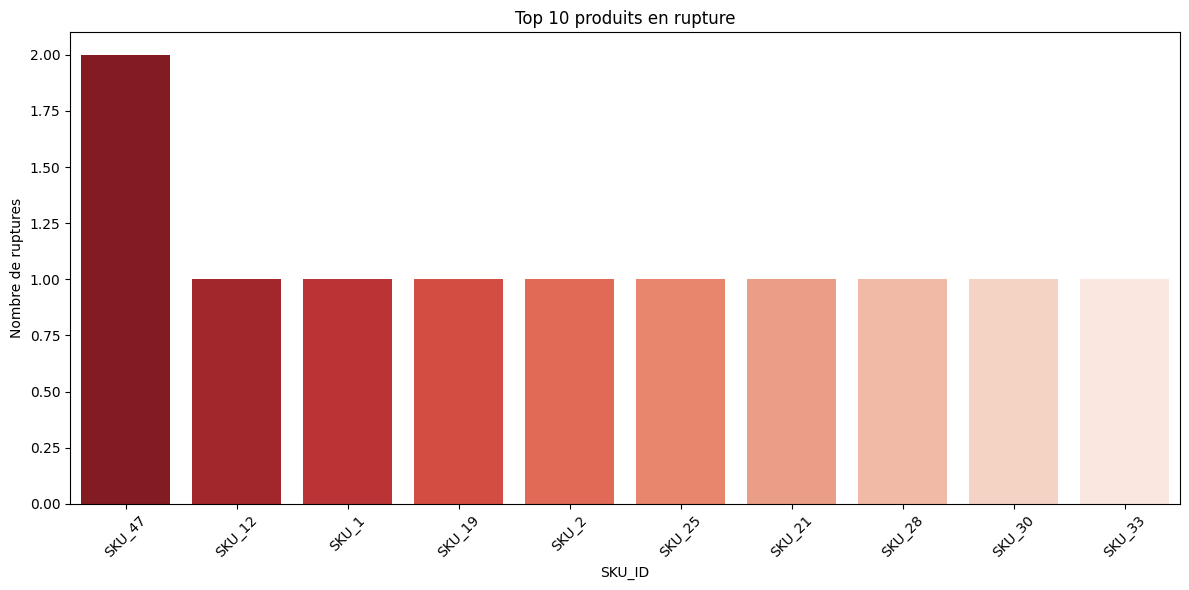

/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/1226781779.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/1226781779.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


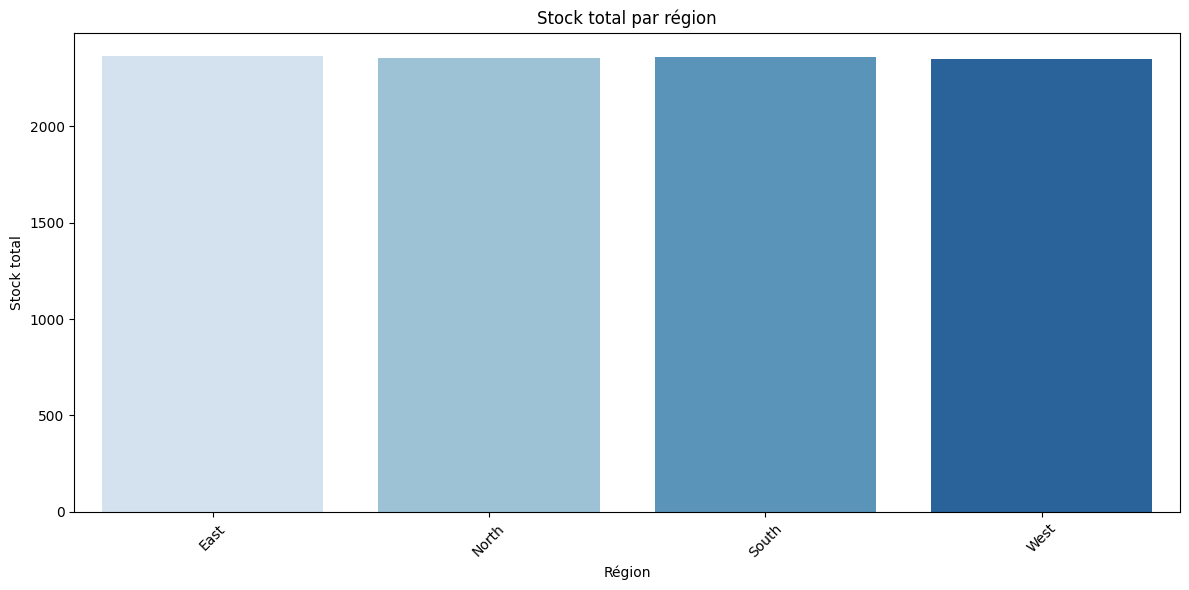

/var/folders/3w/vflp_j9j43bdkfmgxxb92x7w0000gn/T/ipykernel_89608/1226781779.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


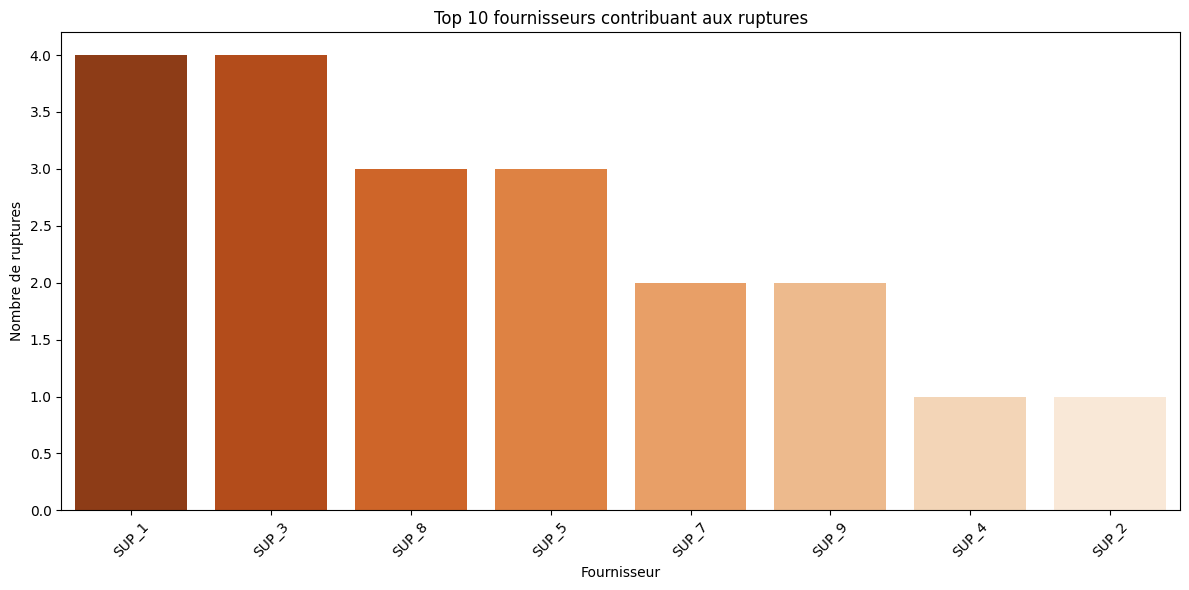

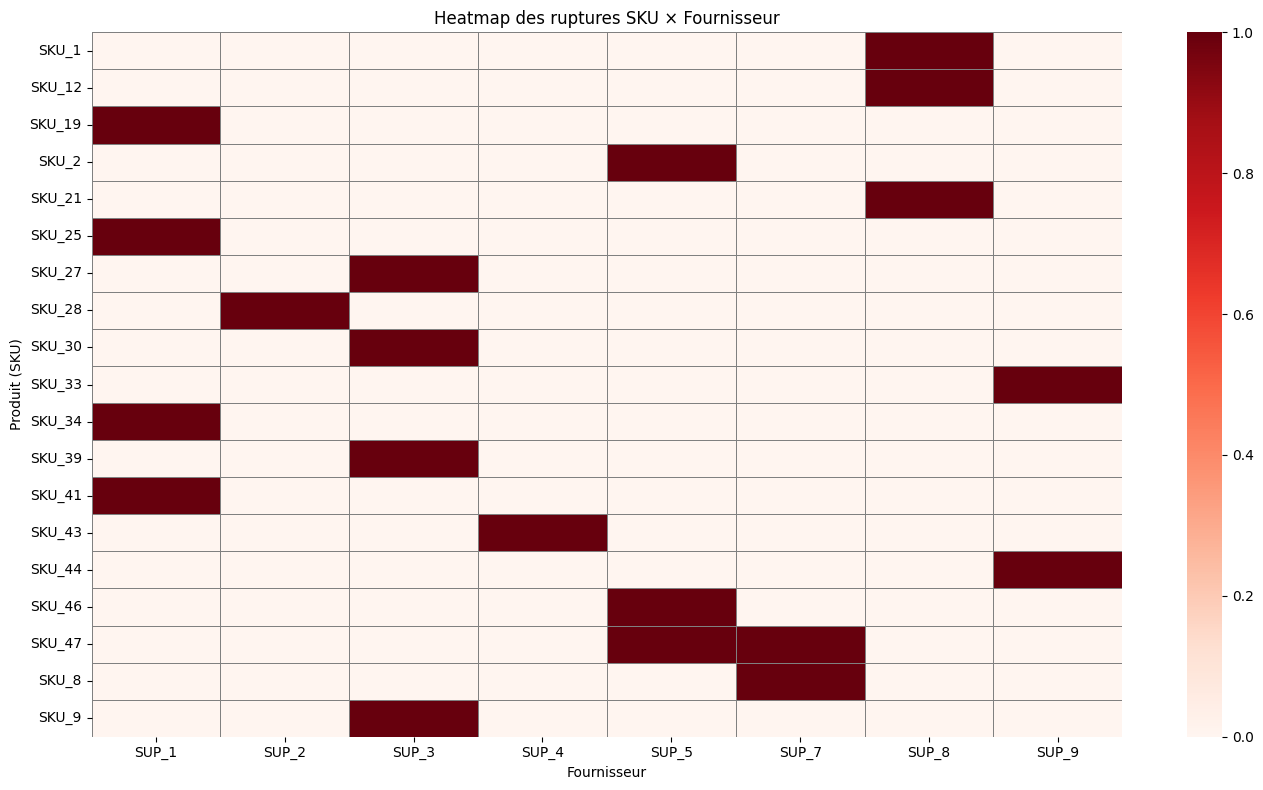

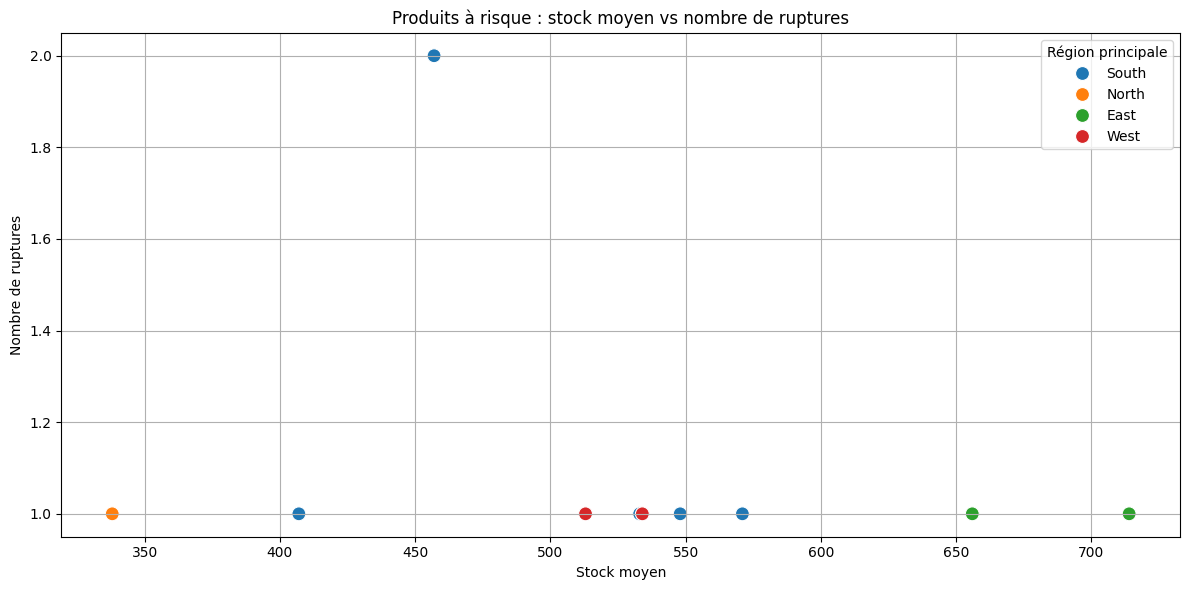

Tous les fichiers exportés dans exports_powerbi/
Export Tableau...
Graphiques Jupyter...
Pipeline terminé ! Fichiers prêts pour Tableau Public.


In [73]:
#automatisation de tout le processus :
def run_pipeline():
    df = pd.read_csv('../raw_data/supply_chain_dataset1.csv')
    df.head()
    print("Chargement des données...")

    # Infos sur les colonnes et types :
    df.info()

# Statistiques descriptives pour les colonnes numériques :
    df.describe()

# Vérifier les doublons :
    df.duplicated().sum()

# Vérifier les valeurs manquantes :
    df.isnull().sum()
    print("Analyse et stats...")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop_duplicates()

#vérif des IDs :
    df['SKU_ID'] = df['SKU_ID'].str.strip()
    df['Warehouse_ID'] = df['Warehouse_ID'].str.strip()
    df['Supplier_ID'] = df['Supplier_ID'].str.strip()
    df['Region'] = df['Region'].str.strip()

#création de nouvelles colonnes :
    df['Stock_After_Sale'] = df['Inventory_Level'] - df['Units_Sold']
    df['Inventory_Value'] = df['Inventory_Level'] * df['Unit_Cost']
    df = predict_stockout(df)

    
    #Visualisation des ruptures par produit
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=top10_stockouts,
        x="SKU_ID",
        y="Nb_Ruptures",
        palette="Reds_r"
)
    plt.title("Top 10 produits en rupture")
    plt.xlabel("SKU_ID")
    plt.ylabel("Nombre de ruptures")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualisation des stocks par région :
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=pivot_stocks,
        x="Region",
        y="Inventory_Level",
        estimator=sum,  # somme des stocks par région
        ci=None,
        palette="Blues"
)
    plt.title("Stock total par région")
    plt.xlabel("Région")
    plt.ylabel("Stock total")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Top 10 fournisseurs par nombre de ruptures
    top_fournisseurs = (
        ruptures.groupby("Supplier_ID")
        .agg(Nb_Ruptures=("Stockout_Flag", "sum"))
        .reset_index()
        .sort_values("Nb_Ruptures", ascending=False)
        .head(10)
)

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=top_fournisseurs,
        x="Supplier_ID",
        y="Nb_Ruptures",
        palette="Oranges_r"
)
    plt.title("Top 10 fournisseurs contribuant aux ruptures")
    plt.xlabel("Fournisseur")
    plt.ylabel("Nombre de ruptures")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Heatmap SKU × Fournisseur pour visualiser dépendances critiques
    pivot_heatmap = (
        ruptures.pivot_table(
            index="SKU_ID",
            columns="Supplier_ID",
            values="Stockout_Flag",
            aggfunc="sum",
            fill_value=0
    )
)

    plt.figure(figsize=(14,8))
    sns.heatmap(
        pivot_heatmap,
        cmap="Reds",
        linewidths=0.5,
        linecolor="gray"
)
    plt.title("Heatmap des ruptures SKU × Fournisseur")
    plt.xlabel("Fournisseur")
    plt.ylabel("Produit (SKU)")
    plt.tight_layout()
    plt.show()


# Scatter Stock moyen × Nb de ruptures (produits à risque)
    plt.figure(figsize=(12,6))
    sns.scatterplot(
        data=top10_stockouts,
        x="Stock_Moyen",
        y="Nb_Ruptures",
        hue="Region_Principale",
        palette="tab10",
        s=100
)
    plt.title("Produits à risque : stock moyen vs nombre de ruptures")
    plt.xlabel("Stock moyen")
    plt.ylabel("Nombre de ruptures")
    plt.legend(title="Région principale")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    output_dir = "exports_powerbi/"

    os.makedirs(output_dir, exist_ok=True)

#Export prédiction de rupture
    df.to_csv(os.path.join(output_dir, "df_with_risk.csv"), index=False)

# Pivot stocks région/entrepôt
    pivot_stocks.to_csv(os.path.join(output_dir, "stocks_region_entrepot.csv"), index=False)

# Top 10 ruptures
    top10_stockouts.to_csv(os.path.join(output_dir, "top10_ruptures.csv"), index=False)

# Top 10 fournisseurs
    top_fournisseurs.to_csv(os.path.join(output_dir, "top10_fournisseurs.csv"), index=False)

# Heatmap SKU x Fournisseur (table longue pour Power BI)
    heatmap_long = pivot_heatmap.reset_index().melt(id_vars="SKU_ID", var_name="Supplier_ID", value_name="Nb_Ruptures")
    heatmap_long.to_csv(os.path.join(output_dir, "sku_fournisseur_ruptures.csv"), index=False)

    print(f"Tous les fichiers exportés dans {output_dir}")
    print("Export Tableau...")
    print("Graphiques Jupyter...")

    print("Pipeline terminé ! Fichiers prêts pour Tableau Public.")

run_pipeline()